<a href="https://colab.research.google.com/github/LuisaPolicarpo/Project5/blob/main/Prediction_2022_2023_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 1 Criar df com os dados de overnight entre 01/2017 até 11/2022
* 2 Criar um test e um train set
* 3 Verificar neste train e test, em qual dos modelos (ARIMA, SARIMA, Exponential Smoothing) obtemos o menor MSE (mean square error). Linear Regression(Trend)+Avg(Seasonality) não será usado, visto que a trend nao tem uma unica direcao, ela sobe e depois desce.
* 4 O modelo com menor MSE, deverá ser o usado para prever os dados de 12/2022 até 12/2023.

In [ ]:
import pandas as pd

In [ ]:
link_2017_2022 = 'https://raw.githubusercontent.com/LuisaPolicarpo/Project5/main/df_final_2017_2022.csv'
df_2017_2022 = pd.read_csv(link_2017_2022)

In [ ]:
df_2017_2022.sort_values(by='Date', inplace=True)

In [ ]:
df_2017_2022['Date'] = pd.to_datetime(df_2017_2022['Date'])

In [ ]:
df_2017_2022.set_index('Date', inplace=True)

In [ ]:
df=df_2017_2022
df.tail(24)

In [ ]:
#df['Date'] = pd.to_datetime(df['Date_mutation']) #DOUBT: why doesn't work?
#df.set_index('Date', inplace=True) #setting date as index

In [ ]:
#Defining the test si<e and the train size
test_size_percentage = 0.25 #17.75 months (from April to December 2019)
test_size = int(test_size_percentage * df.shape[0]) #17 lines
train_size_initial = df.shape[0] - test_size #44 lines

train_set = df['sleeps'].iloc[:train_size_initial] #1st 44 months
test_set = df['sleeps'].iloc[train_size_initial:] #last 17 months

In [ ]:
# length check
print(train_set.shape[0] + test_set.shape[0] == df.shape[0])

True


Calculate the mean square error on the ARIMA

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

auto_arima(train_set) #What was this for? A: To obtain the best order, written bellow.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

def arima_forecast(tme_sries):
  arima = ARIMA(tme_sries, order=(3, 1, 1)).fit()  #I obtained the values order() in auto_arima
  return arima.forecast().iloc[0]

evaluation_df = pd.DataFrame(range(0, test_size), columns = ['forecast'])
evaluation_df['test'] = list(test_set)
evaluation_df['forecast'] = evaluation_df['forecast']\
  .apply(lambda n: arima_forecast(df['sleeps'].iloc[:train_size_initial + n]))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dat

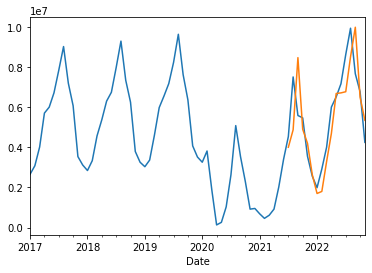

In [ ]:
df['sleeps'].plot()
evaluation_df.set_index(test_set.index)['forecast'].plot() #DOUBT:

In [ ]:
#EXPONENTIAL SMOOTHING
#DOUBT
from statsmodels.tsa.api import ExponentialSmoothing
def expsm_forecast(tme_sries):
  es = ExponentialSmoothing(tme_sries).fit(smoothing_level=0.1)
  return es.forecast().iloc[0]

evaluation_df = pd.DataFrame(range(0, test_size), columns = ['forecast'])
evaluation_df['test'] = list(test_set)
evaluation_df['forecast'] = evaluation_df['forecast']\
  .apply(lambda n: expsm_forecast(df['sleeps'].iloc[:train_size_initial + n])) #to do: a list of decimals in smoothing_level, the minor mse wins (hyper tunning). / Works in Gridsearch?

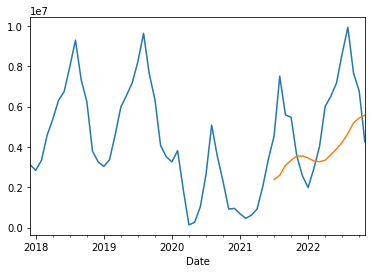

In [ ]:
#With the window re-sized
df['sleeps'].iloc[df.shape[0] - 60:].plot() #DOUBT: which interval should I put here? The values are so different
evaluation_df.set_index(test_set.index)['forecast'].iloc[evaluation_df.shape[0] - 60:].plot()

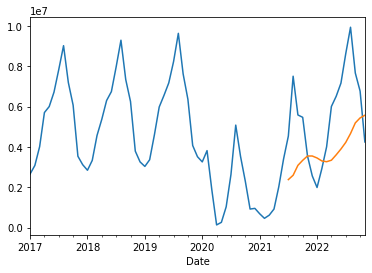

In [ ]:
#Without resizing the window
df['sleeps'].plot() #DOUBT: which interval should I put here? The values are so different
evaluation_df.set_index(test_set.index)['forecast'].plot()

Seasonal Decompose

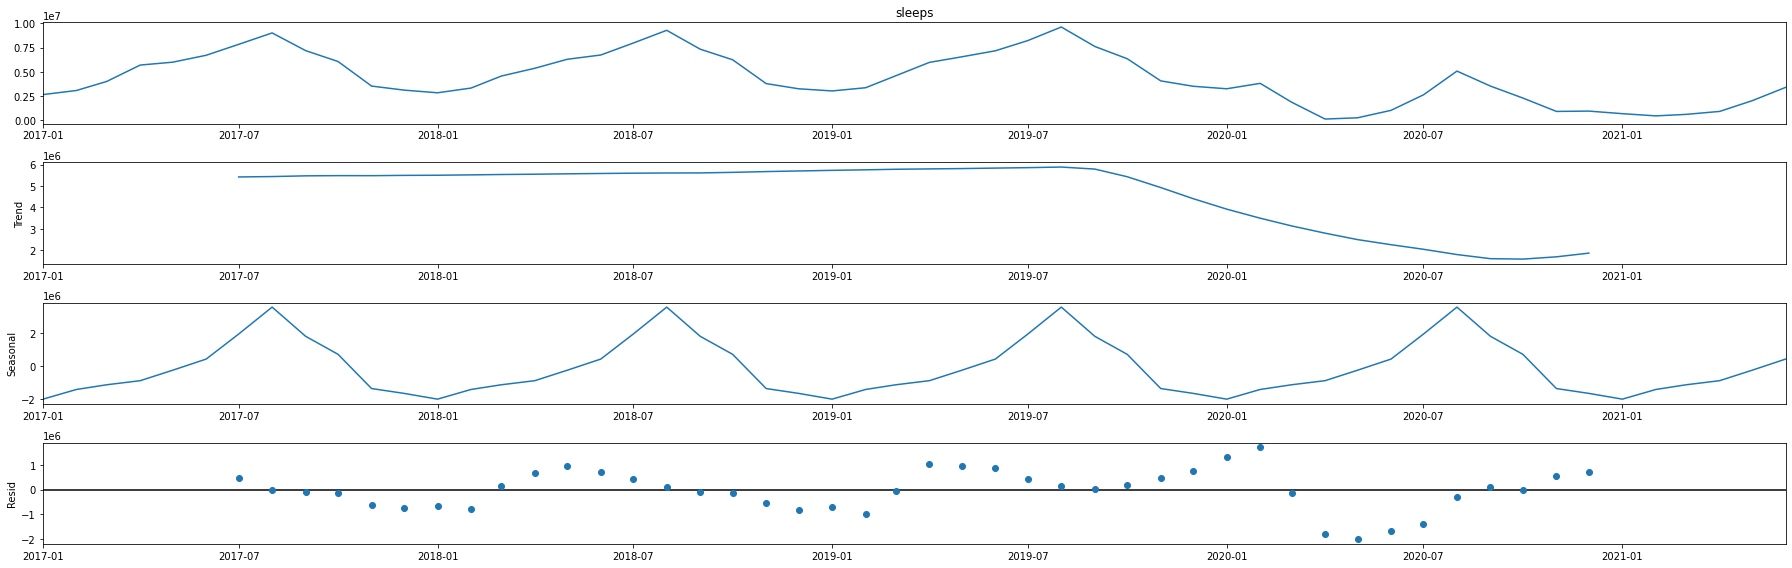

In [ ]:
#Seasonal decompose of the train set
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 25, 8

decomposition = sm.tsa.seasonal_decompose(x = train_set, period = 12, model='additive')
fig = decomposition.plot()
plt.show()

#Doubt: Why the trend finishes earlier than the end of the dataset? A: Because the model is using a method called central trend.

In [ ]:
#decomposition.trend
type(decomposition.trend)

pandas.core.series.Series

In [ ]:
#passar os valores da trend para dataframe
df_trend=decomposition.trend.to_frame()

In [ ]:
#pass test values to dataframe
df_test_set=test_set.to_frame()

In [ ]:
#insert an ID to the trend months
df_trend.insert(0, 'ID_trend', range(0, len(df_trend)))

In [ ]:
df_trend.tail()

,ID_trend,trend
Date,,
2021-02-01,49,NaN
2021-03-01,50,NaN
2021-04-01,51,NaN
2021-05-01,52,NaN
2021-06-01,53,NaN


In [ ]:
#insert an ID to the test_set months
df_test_set.insert(0, 'ID_test', range(len(df_trend), len(df_trend)+len(df_test_set)))

In [ ]:
#transform the trend dataset in the same format of test_set dataset, removing Date from index
df_test_set.reset_index(inplace=True)


In [ ]:
df_test_set


,Date,ID_test,sleeps
0,2021-07-01,54,4538643
1,2021-08-01,55,7507272
2,2021-09-01,56,5585513
3,2021-10-01,57,5468960
4,2021-11-01,58,3556760
5,2021-12-01,59,2564574
6,2022-01-01,60,1988869
7,2022-02-01,61,2920471
8,2022-03-01,62,4006723
9,2022-04-01,63,6006236


In [ ]:
df_trend

,ID_trend,trend
Date,,
2017-01-01,0,NaN
2017-02-01,1,NaN
2017-03-01,2,NaN
2017-04-01,3,NaN
2017-05-01,4,NaN
2017-06-01,5,NaN
2017-07-01,6,5.421557e+06
2017-08-01,7,5.439788e+06
2017-09-01,8,5.473412e+06


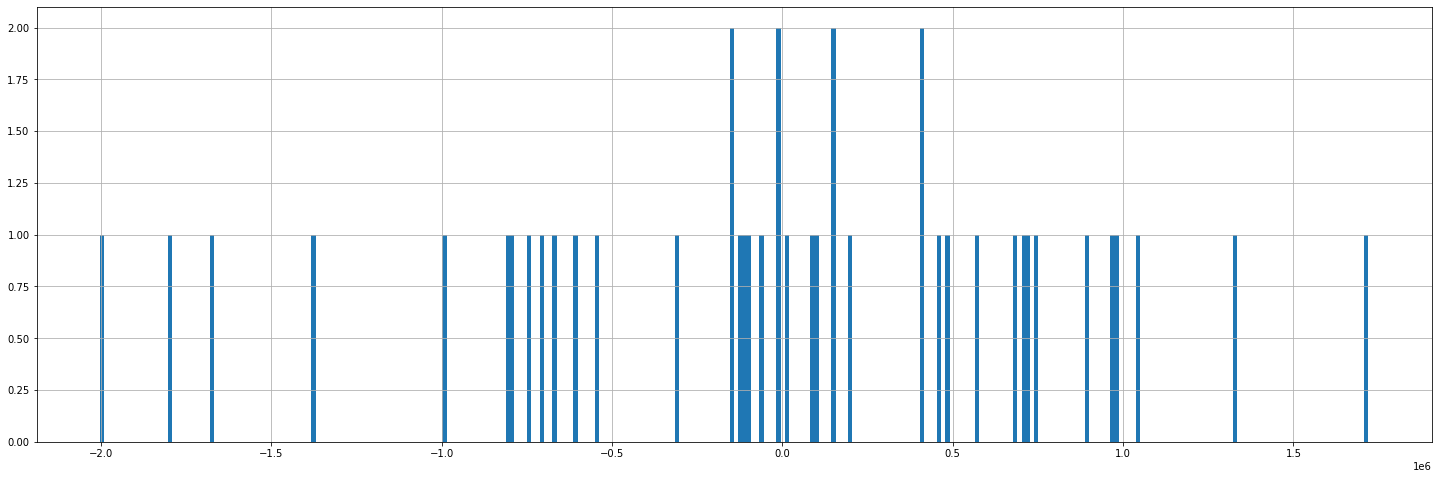

In [ ]:
#Residuals analysis
#decomposition.resid.describe()
#decomposition.resid.plot()
decomposition.resid.hist(bins=300) #DOUBT: Confirm with cristina if the more frequent number (-5000) is a problem

In this case since there is a trend going up and then down. I should just calculate the MSE in the methods: Arima, Sarima and Exponential Smoothing.

In [ ]:
#I should calculate the MSE of all models above.